This project was made by :

Eliott Vigier - eliottaxel.vigier@studio.unibo.it

Mattia Maranzana - mattia.maranzana@studio.unibo.it

Oğuz Kağan Koçak - oguzkagan.kocak@studio.unibo.it

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


To understand the dataset better, we inspected the number of elements and their shapes. This inspection revealed that the dataset contains a diverse range of images. However, some images contain other products besides the labeled item, which introduces noise and complexity into the classification task. We also decided to compute the mean and variance of the dataset to normalize our images

In [2]:
from pathlib import Path
from PIL import Image
from typing import List, Tuple

import torch
from torch import Tensor,device
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, AdamW
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import random
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(45)

In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_dataset = GroceryStoreDataset(split='train',transform=transform)
val_dataset = GroceryStoreDataset(split='val',transform=transform)
test_dataset = GroceryStoreDataset(split='test',transform=transform)
train_dataset.__len__(),val_dataset.__len__(),test_dataset.__len__()

(2640, 296, 2485)

In [6]:
def check_image_shapes(dataset):
    for i in range(dataset.__len__()):
        img, label = dataset[i]
        w, h = 0,0
        if img.shape[1] > w:
          w = img.shape[1]
        if img.shape[2] > h:
          h = img.shape[2]
    return w,h

w_t,h_t = check_image_shapes(train_dataset)
w_v,h_v = check_image_shapes(val_dataset)
#w_T,h_T = check_image_shapes(test_dataset)
w_t,h_t,w_v,h_v

(464, 348, 348, 348)

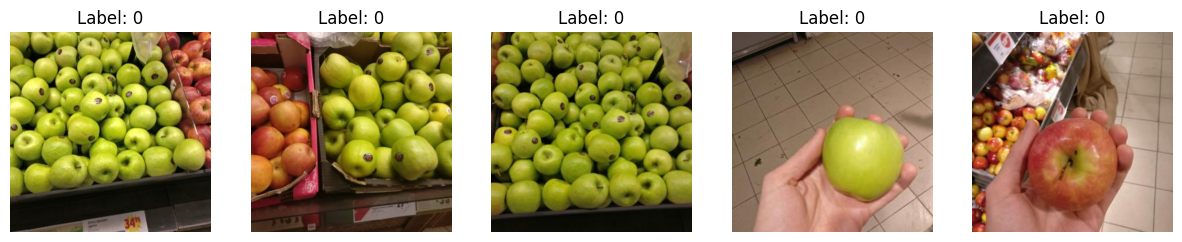

In [9]:
# Function to display some images
def display_images(dataset, num_images=5, offset=100):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        img, label = dataset[i+offset]
        img = transforms.ToPILImage()(img)  # Convert tensor back to PIL image
        axs[i].imshow(img)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.show()

# Display some images from the train dataset
display_images(train_dataset, num_images=5)

In [ ]:
image_height, image_width, image_channels = 348,348,3
# Define the transform to resize images
resize_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor()
])

# Load the training dataset with the resizing transform
train_dataset = GroceryStoreDataset(split='train',transform=resize_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Initialize variables to store the mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

# Compute mean and standard deviation
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.5306, 0.3964, 0.2564])
Std: tensor([0.2325, 0.2093, 0.1781])


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

### Network Design
#### Transformation
To prepare the images for training, we applied a series of transformations that enhance the dataset and improve the model's ability to generalize. The transformations used are:

- Random Resized Crop: This transformation crops the image to a random size and aspect ratio, then resizes it to the target dimensions (348x348 pixels). This helps the model become invariant to different scales and viewpoints of the objects. Additionally, since the labeled image could be close to other objects, this transformation attempts to mitigate this issue by focusing on random regions of the image, potentially excluding unwanted objects
- Random Horizontal Flip: This transformation flips the image horizontally with a probability of 0.5
- ToTensor: This transformation converts the image to a tensor
- Normalize: This transformation normalizes the image tensor using the computed mean and standard deviation of the dataset

In the section "Test with different transformations," we demonstrated the importance of each of these transformations. While every transformation contributes to improving the model's generalization capability, the Random Resized Crop had the most significant impact.

#### Neural net
Inspired by the VGG architecture, we designed a smaller network that leverages the simplicity and effectiveness of 3x3 convolutions followed by max pooling.

After each convolutional layer, a subsequent max pooling layer downsamples the feature maps by a factor of 2. This downsizing reduces spatial dimensions while preserving essential features, which enhances the network's ability to learn robust representations. Additionally, this process decreases computational demands, making training faster even on less powerful GPUs.


To further enhance feature extraction, we opted to double the number of channels after each convolutional layer and max pooling combination. This strategy empowers the network to capture increasingly intricate features as it progresses deeper into the layers.


After the 4th convolution and pooling block, we include three fully connected (FC) layers. These layers gradually reduce the dimensionality of the feature space.


#### Hyperparameters

Throughout our experimentation, we explored various settings to optimize performance:

- number of channels for convolution: we tested 8, 16, and 32 channels per convolutional layer. Although 16 channels performed slightly better, results across these settings were consistently close.

- learning rates: experimentation with learning rates of 0.0001, 0.001, and 0.01 revealed that rates smaller than 0.001 resulted in poor performance, even on the training set.

- batch size: we evaluated batch sizes of 4, 8, and 16, with similar outcomes across these choices.

- label smoothing: testing label smoothing values of 0, 0.1, and 0.2 showed that a small smoothing value of 0.1 marginally improved network performance

- Among different optimizers, SGD with weight decay (0.01, 0.1) performed poorly, while AdamW demonstrated comparable results to our primary optimizer.

These experiments and their outcomes are reported in the following section.



In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, label_smoothing=0, save_model=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    training_values = []
    validation_values = []
    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels,label_smoothing=label_smoothing)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples
        training_values.append((train_acc,train_loss))

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                validation_values.append((val_acc,val_loss))

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose: #and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.2f} - train acc {train_acc:.2f}" + ("" if val_dl is None else f" - valid loss {val_loss:.2f} - valid acc {val_acc:.2f}"))

            if  save_model and val_acc >= 0.60:
                best_params = model.state_dict()
                torch.save(best_params, "A2.pth")
                best_epoch = e
                break

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.2f}")

    return (best_val_acc, best_params, best_epoch,training_values,validation_values)

In [ ]:
image_height, image_width, image_channels = 348,348,3
num_classes = train_dataset.get_num_classes()

transform_2 = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(image_height, image_width),antialias=True),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])
train_dataset = GroceryStoreDataset(split='train',transform=transform_2)
val_dataset = GroceryStoreDataset(split='val',transform=val_transforms)
#test_dataset = GroceryStoreDataset(split='test',transform=transform_2)

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [ ]:
class ExtendedCNN(nn.Module):
    def __init__(self,channels=16, num_classes=num_classes):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*4, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=channels*4, out_channels=channels*8, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1
        def conv2d_compute_size(conv_number,kernels,max_poolings):  #max pooling e.g. [1,0,1] if 1 then there is a max_pool
          image_w = image_width
          for i in range(conv_number):
            image_w = conv2d_size_out(image_w, kernel_size=kernels[i])
            if max_poolings[i] == 1:
              image_w = image_w//2
          return image_w

        image_w = conv2d_compute_size(4,[3,3,3,3],[1,1,1,1])
        linear_input_size = image_w * image_w * channels*8

        # Define fully connected layers
        self.fc1 = nn.Linear(linear_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
def test_plot(model,hyperparameters):

  epochs = hyperparameters['num_epochs']
  if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
  elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
  elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
  # Training
  best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
      model,
      train_loader,
      epochs,
      optimizer,
      val_loader,
      verbose=False,
      label_smoothing = hyperparameters['label_smoothing'],
  )
  training_acc = []
  training_loss = []
  validation_acc=[]
  validation_loss=[]

  for train,val in zip(training_values,validation_values):
    training_acc.append(round(train[0], 2))
    training_loss.append(round(train[1], 2))
    validation_acc.append(round(val[0], 2))
    validation_loss.append(round(val[1], 2))

  print(f"Best epoch {best_epoch}, best acc {best_val_acc:.2f}")

  # Plotting
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

  ax1.plot(training_acc, label='Training Accuracy', marker='o')
  ax1.plot(validation_acc, label='Validation Accuracy', marker='o')
  ax1.set_title('Training and Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend()

  ax2.plot(training_loss, label='Training Loss', marker='o')
  ax2.plot(validation_loss, label='Validation Loss', marker='o')
  ax2.set_title('Training and Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend()

  plt.tight_layout()
  plt.show()

### Proposed solution

In [ ]:
hyperparameters = {
    "batch_size": 8,
    "num_epochs": 60,

    "lr": 0.001,
    "optimizer":'Adam',
    "wd": 0,
    "label_smoothing": 0.1
}

  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 54, best acc 0.61


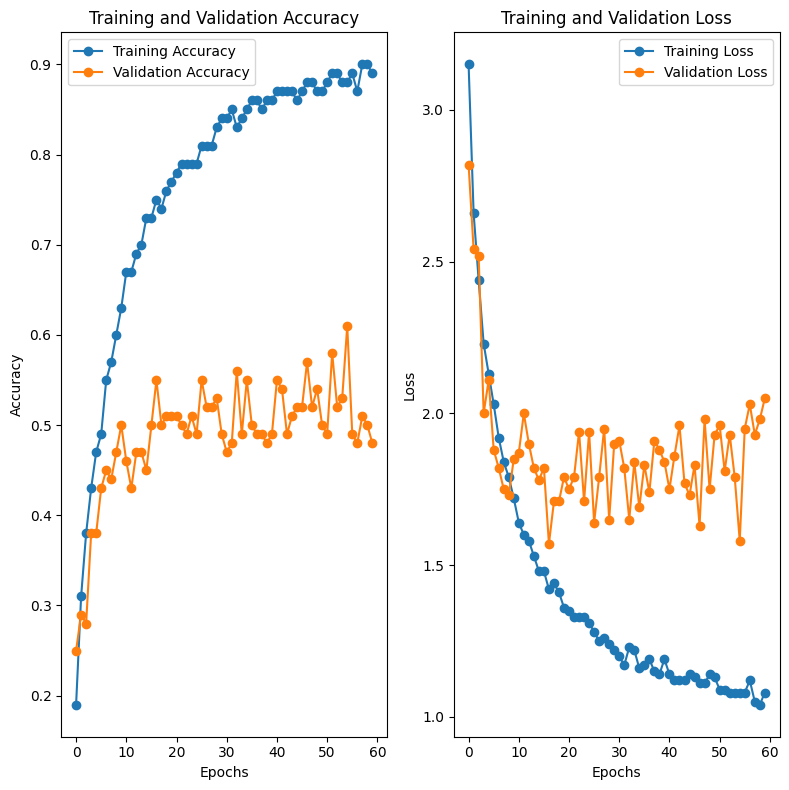

In [ ]:
my_model = ExtendedCNN(
    num_classes = num_classes,
)
my_model.to(device)

test_plot(my_model,hyperparameters)

### Test different Channels for convolution

Testing with channels = 8


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 37, best acc 0.54


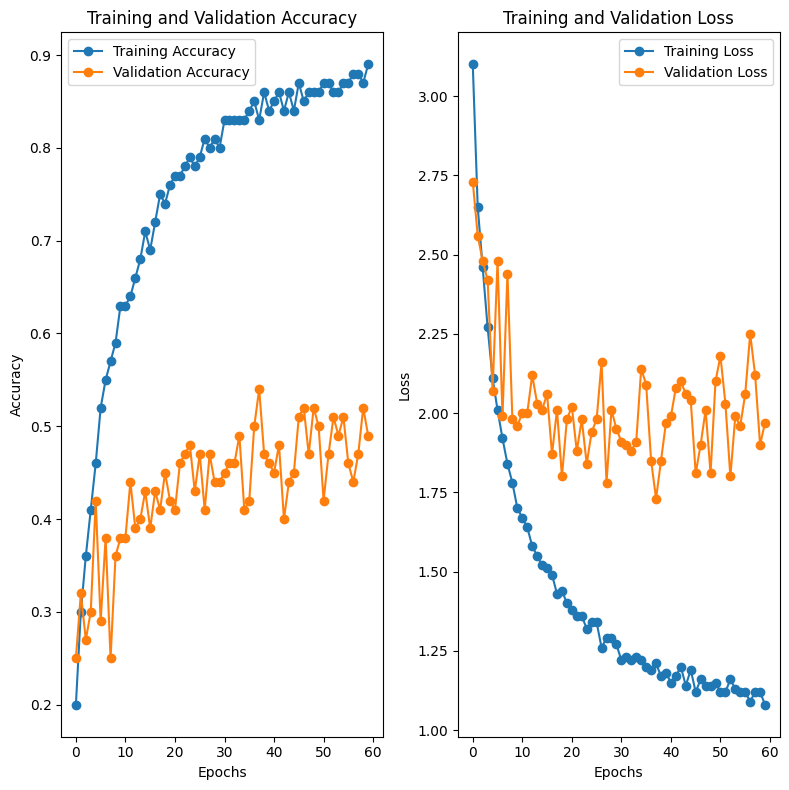

--------------------------------------------------------------------------------
Testing with channels = 32


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 55, best acc 0.59


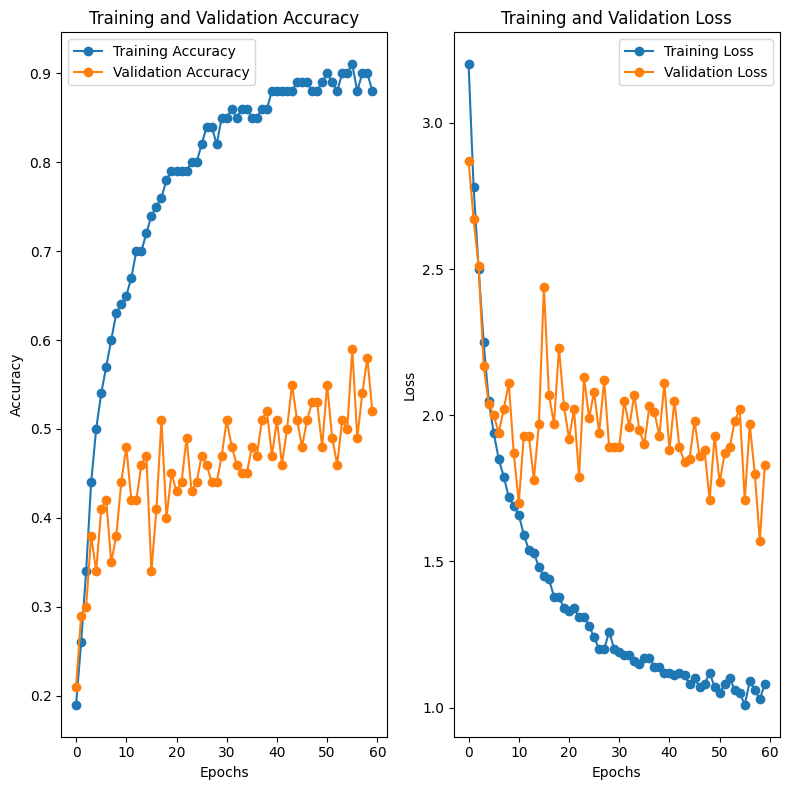

--------------------------------------------------------------------------------


In [ ]:
channels = [8,32]
for ch in channels:
    print(f"Testing with channels = {ch}")
    my_model = ExtendedCNN(
        num_classes = num_classes,
        channels = ch
    )
    my_model.to(device)

    test_plot(my_model,hyperparameters)
    print('-'*80)

### Test lr

Testing with learning rate = 0.0001


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 51, best acc 0.51


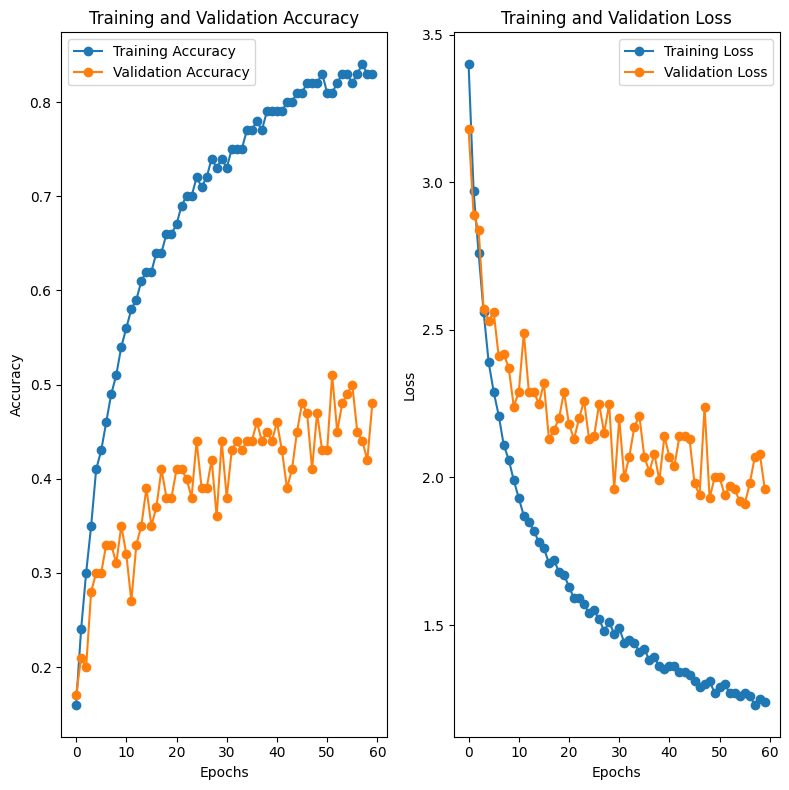

--------------------------------------------------------------------------------
Testing with learning rate = 0.01


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 2, best acc 0.10


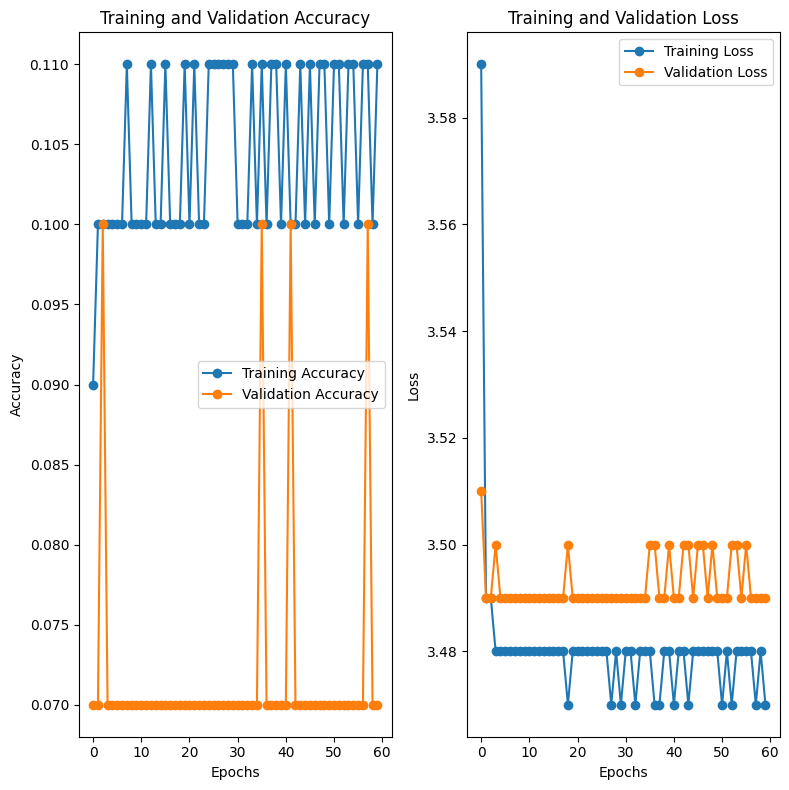

--------------------------------------------------------------------------------


In [ ]:
for lr in [0.0001,0.01]:
    print(f"Testing with learning rate = {lr}")
    hyperparameters['lr']=lr
    my_model = ExtendedCNN(num_classes = num_classes)
    my_model.to(device)

    test_plot(my_model,hyperparameters)
    print('-'*80)
hyperparameters['lr']=0.001

### Test batch size

  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 43, best acc 0.56


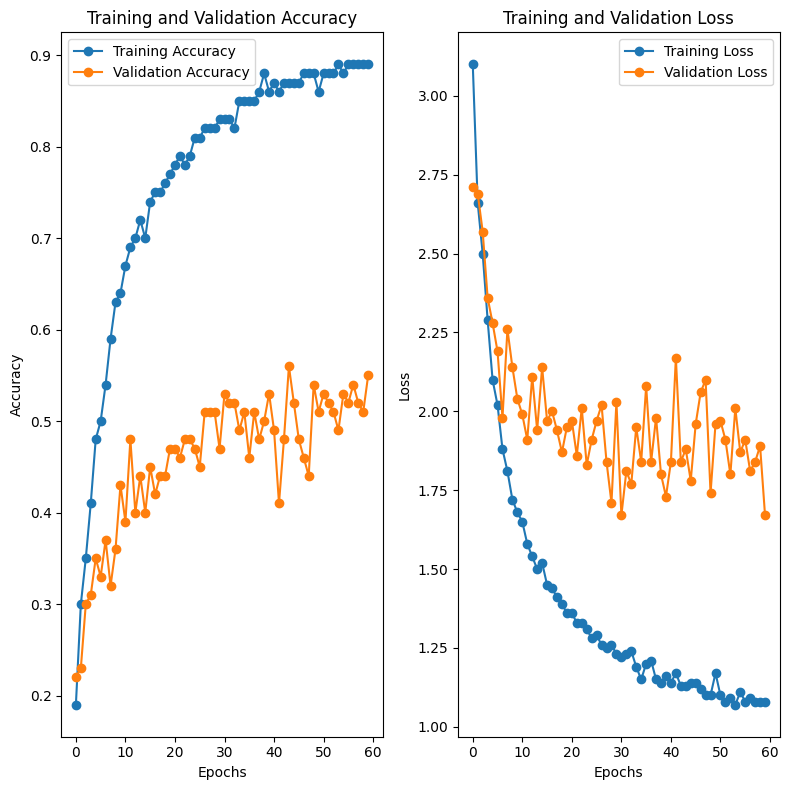

In [ ]:
my_model = ExtendedCNN(
    num_classes = num_classes,
)
my_model.to(device)
hyperparameters['batch_size']=16
test_plot(my_model,hyperparameters)

Testing with batch_size = 4


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 40, best acc 0.57


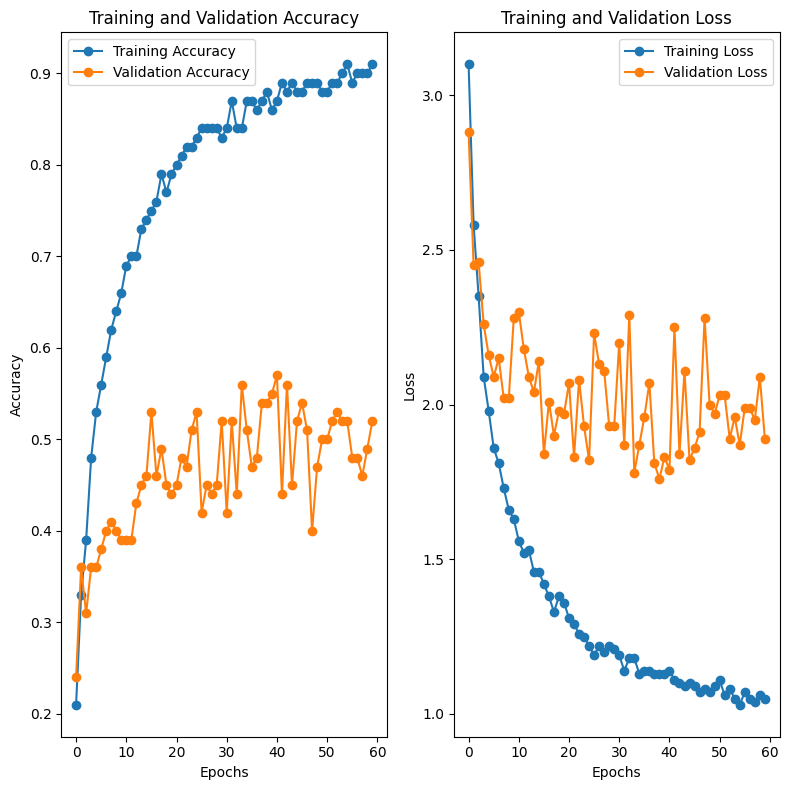

In [ ]:
print(f"Testing with batch_size = {4}")
hyperparameters['batch_size']=4
my_model = ExtendedCNN(num_classes = num_classes)
my_model.to(device)

test_plot(my_model,hyperparameters)
hyperparameters['batch_size']=8

### Test label smoothing

Testing with label smoothing = 0


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 22, best acc 0.57


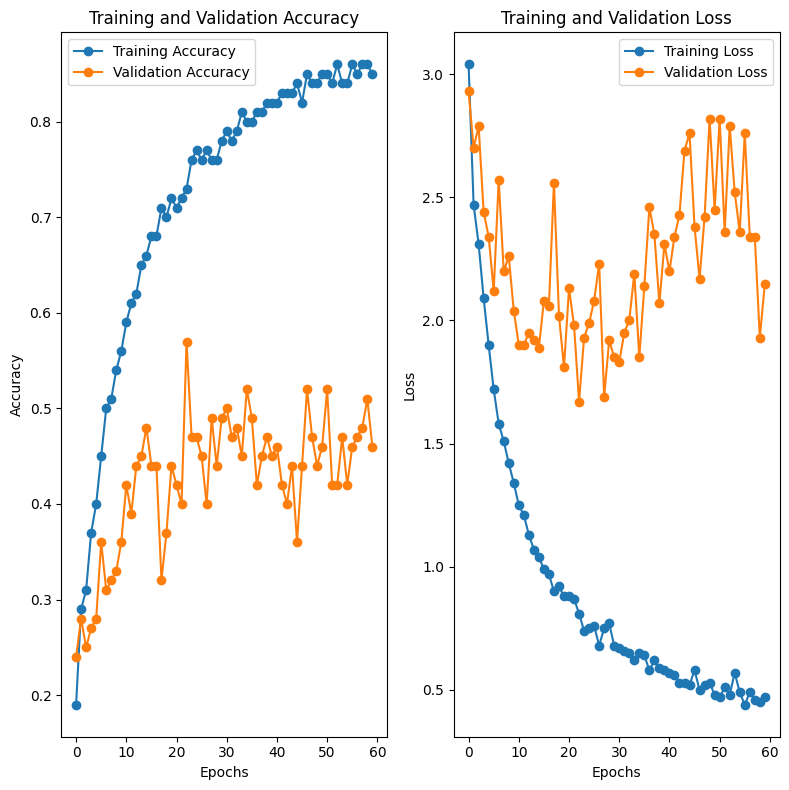

--------------------------------------------------------------------------------
Testing with label smoothing = 0.2


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 56, best acc 0.56


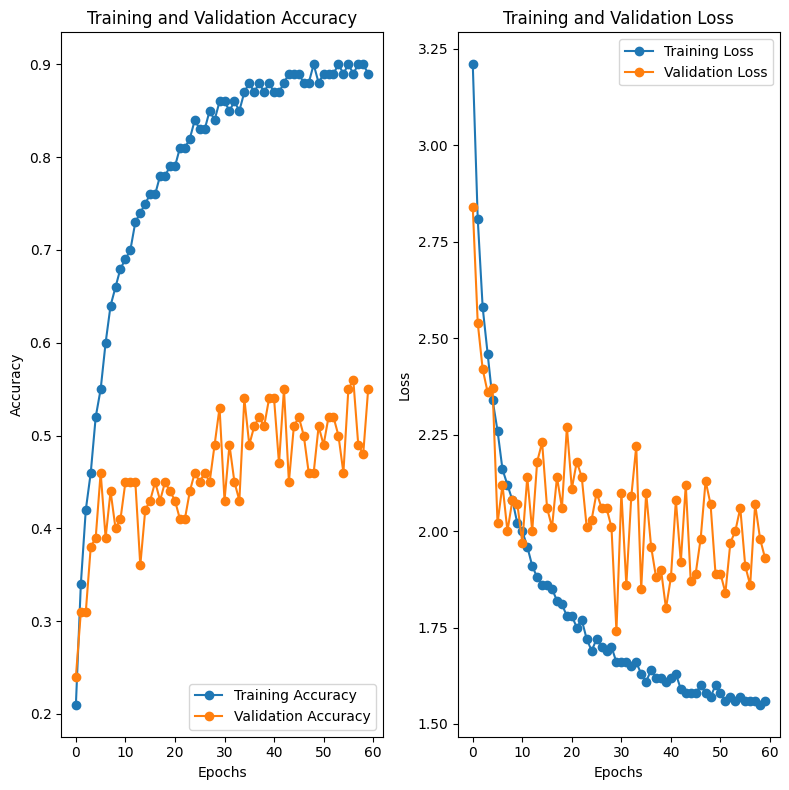

--------------------------------------------------------------------------------


In [ ]:
for ls in [0,0.2]:
    print(f"Testing with label smoothing = {ls}")
    hyperparameters['label_smoothing']=ls
    my_model = ExtendedCNN(num_classes = num_classes)
    my_model.to(device)

    test_plot(my_model,hyperparameters)
    print('-'*80)
hyperparameters['label_smoothing']=0.1

### Test different optimizers

Testing with SGD and weight decay = 0.01


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 53, best acc 0.30


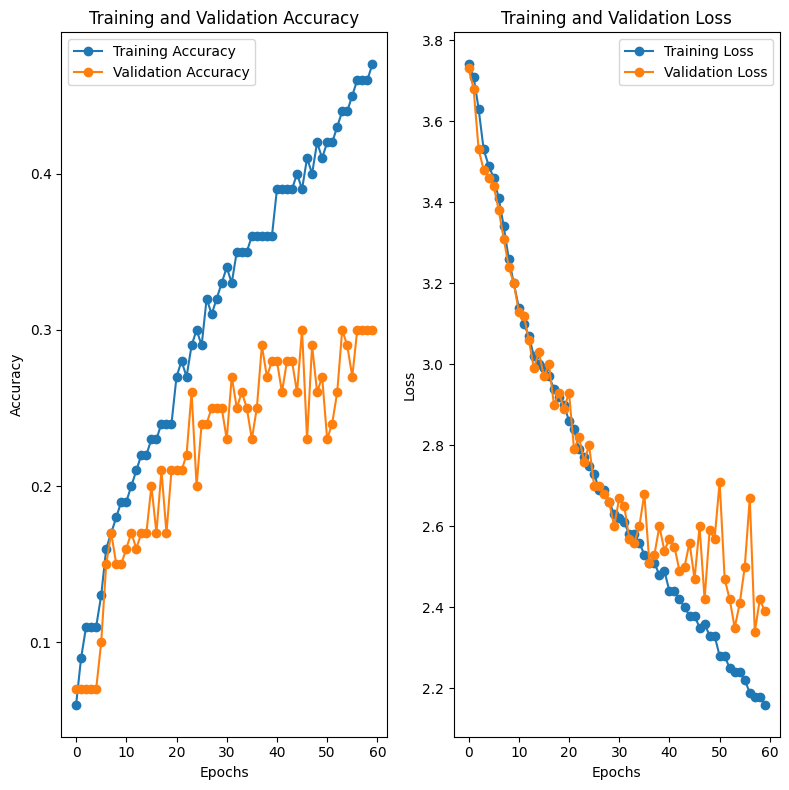

--------------------------------------------------------------------------------
Testing with SGD and weight decay = 0.1


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 8, best acc 0.14


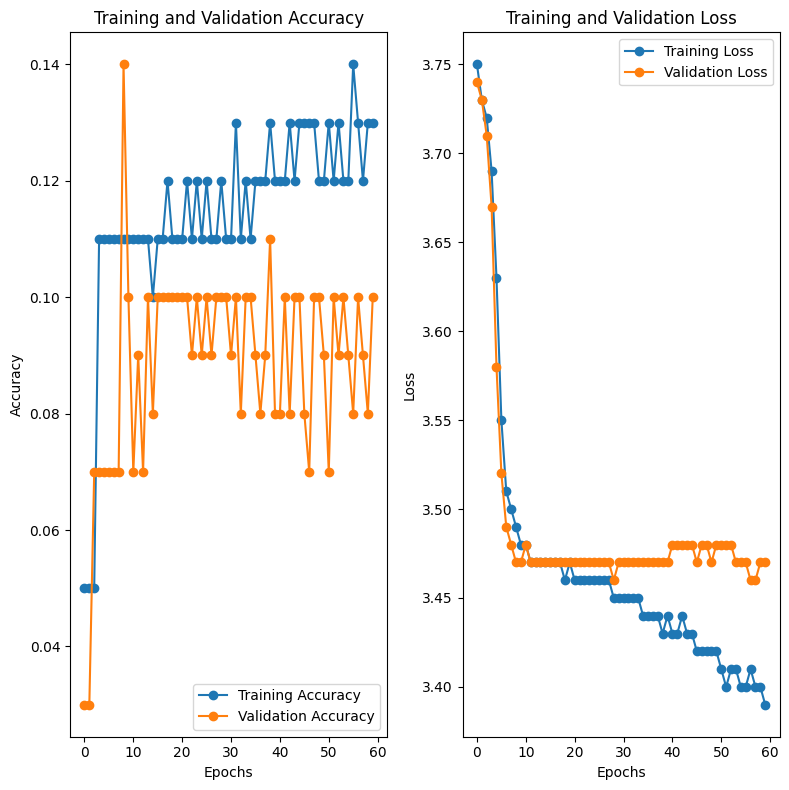

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'SGD'
for wd in [0.01, 0.1]:
    print(f"Testing with SGD and weight decay = {wd}")
    hyperparameters['wd']=wd
    my_model = ExtendedCNN(num_classes = num_classes)
    my_model.to(device)

    test_plot(my_model,hyperparameters)
    print('-'*80)

Testing with AdamW and weight decay = 0.01


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 58, best acc 0.55


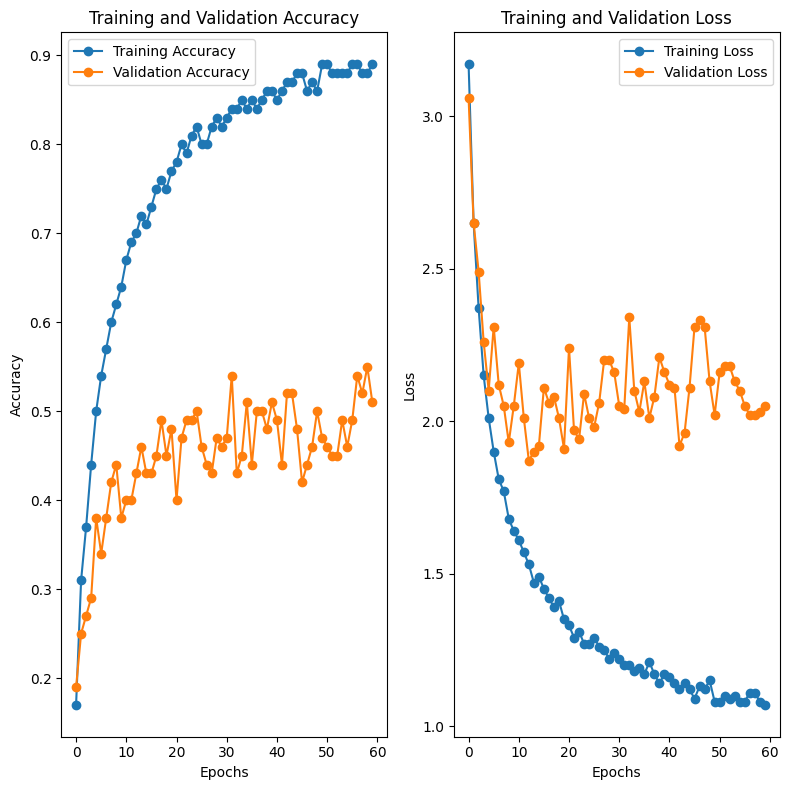

--------------------------------------------------------------------------------
Testing with AdamW and weight decay = 0.1


  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 40, best acc 0.56


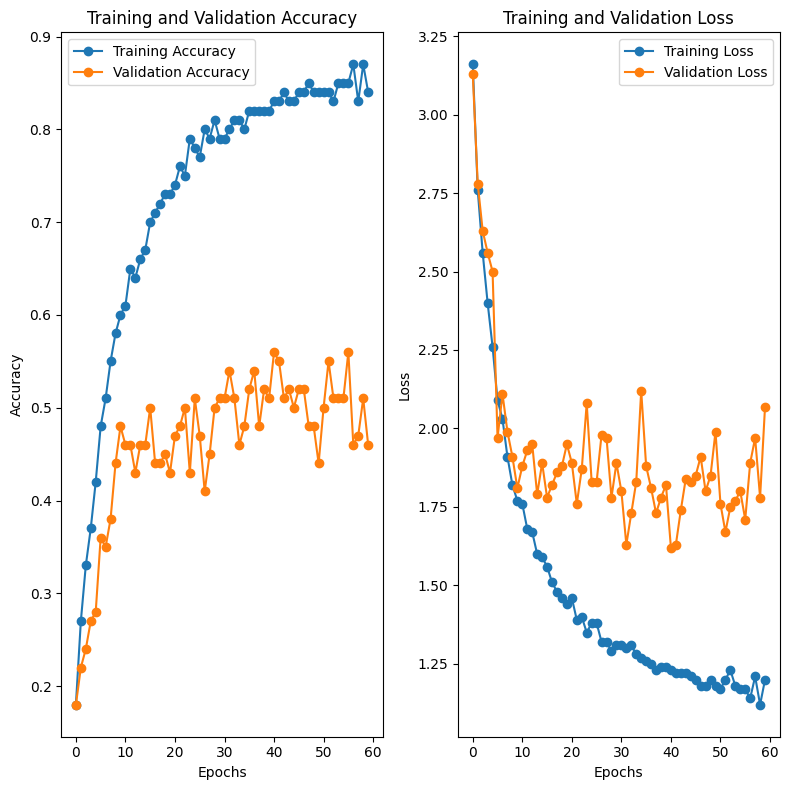

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'AdamW'
for wd in [0.01, 0.1]:
    print(f"Testing with AdamW and weight decay = {wd}")
    hyperparameters['wd']=wd
    my_model = ExtendedCNN(num_classes = num_classes)
    my_model.to(device)

    test_plot(my_model,hyperparameters)
    print('-'*80)

### Test with different transformation

#### No random resized crop

  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 35, best acc 0.44


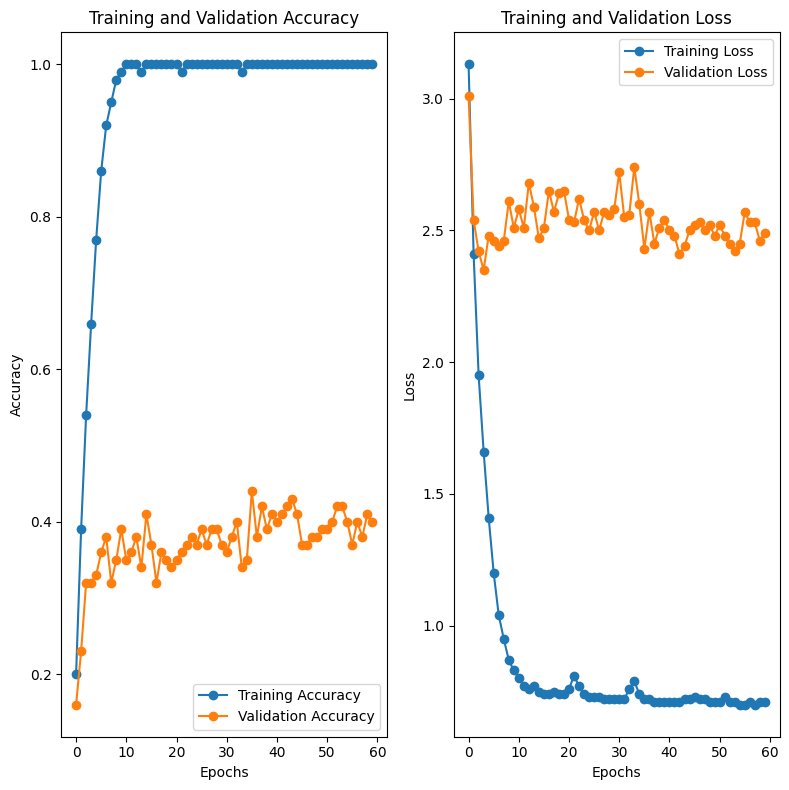

In [ ]:
image_height, image_width, image_channels = 348,348,3
num_classes = train_dataset.get_num_classes()

transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])
train_dataset = GroceryStoreDataset(split='train',transform=transform_resize)
val_dataset = GroceryStoreDataset(split='val',transform=val_transforms)

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

my_model = ExtendedCNN(
    num_classes = num_classes,
)
my_model.to(device)

test_plot(my_model,hyperparameters)

#### No horizontal flip

  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 36, best acc 0.38


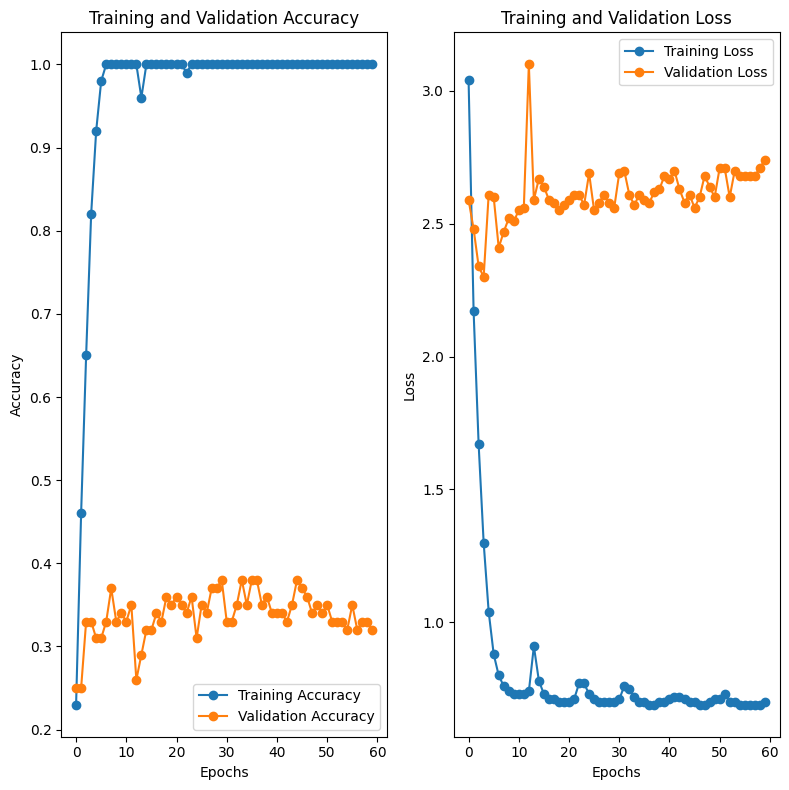

In [ ]:
image_height, image_width, image_channels = 348,348,3
num_classes = train_dataset.get_num_classes()

transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])

train_dataset = GroceryStoreDataset(split='train',transform=transform_resize)
val_dataset = GroceryStoreDataset(split='val',transform=val_transforms)

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

my_model = ExtendedCNN(
    num_classes = num_classes,
)
my_model.to(device)

test_plot(my_model,hyperparameters)

#### No normalization

  0%|          | 0/60 [00:00<?, ?it/s]

Best epoch 29, best acc 0.32


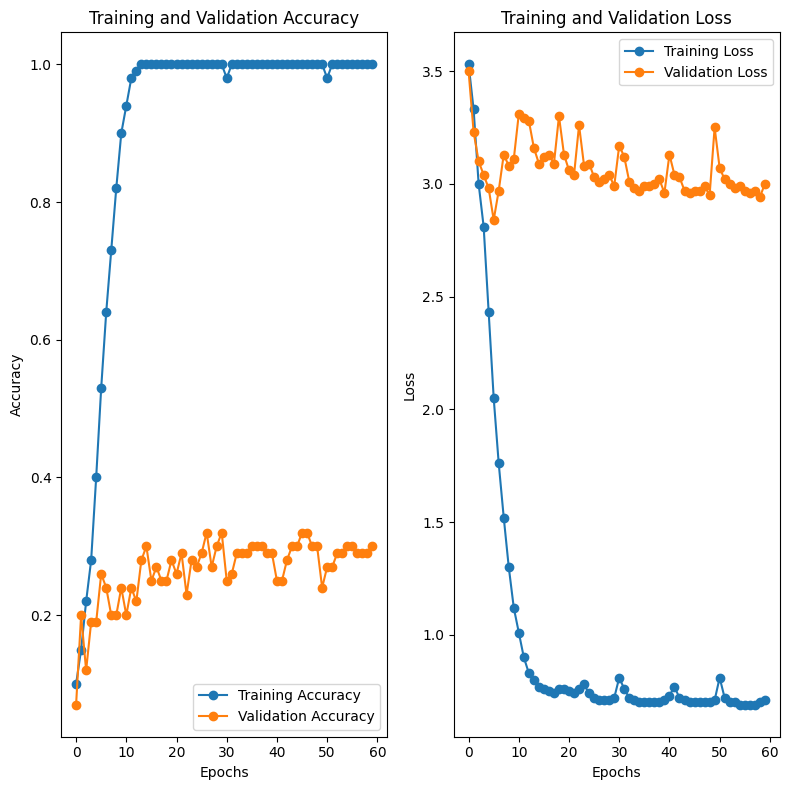

In [ ]:
image_height, image_width, image_channels = 348,348,3
num_classes = train_dataset.get_num_classes()

transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),

])
train_dataset = GroceryStoreDataset(split='train',transform=transform_resize)
val_dataset = GroceryStoreDataset(split='val',transform=val_transforms)

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

my_model = ExtendedCNN(
    num_classes = num_classes,
)
my_model.to(device)

test_plot(my_model,hyperparameters)

# Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

### Resnet Results
In the second part of our assignment, we present the results using our established hyperparameters from the initial experiments. Despite achieving competitive performance, we observed slight overfitting tendencies across various tests.

Consistent with our findings in the first part, the learning rate remains a critical factor influencing accuracy. We noticed significant fluctuations in accuracy with different values, particularly when training the entire network.

Introducing a small label smoothing factor enhanced performance across our experiments.

In contrast to the first part of our assignment, SGD demonstrated superior performance, achieving up to 92% accuracy on the validation set. AdamW showed comparable results to Adam.

These results were obtained by training all the Resnet-18.

Lastly we tried to train just the classifier for some epochs and for the last 10 we unfreeze all the layers, obtaining decent results for Adam and SGD

### Using our hyperparameters

In [ ]:
hyperparameters = {
    "batch_size": 8,
    "num_epochs": 40,

    "lr": 0.001,
    "optimizer":'Adam',
    "wd": 0,
    "label_smoothing": 0.1
}

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 37, best acc 0.82


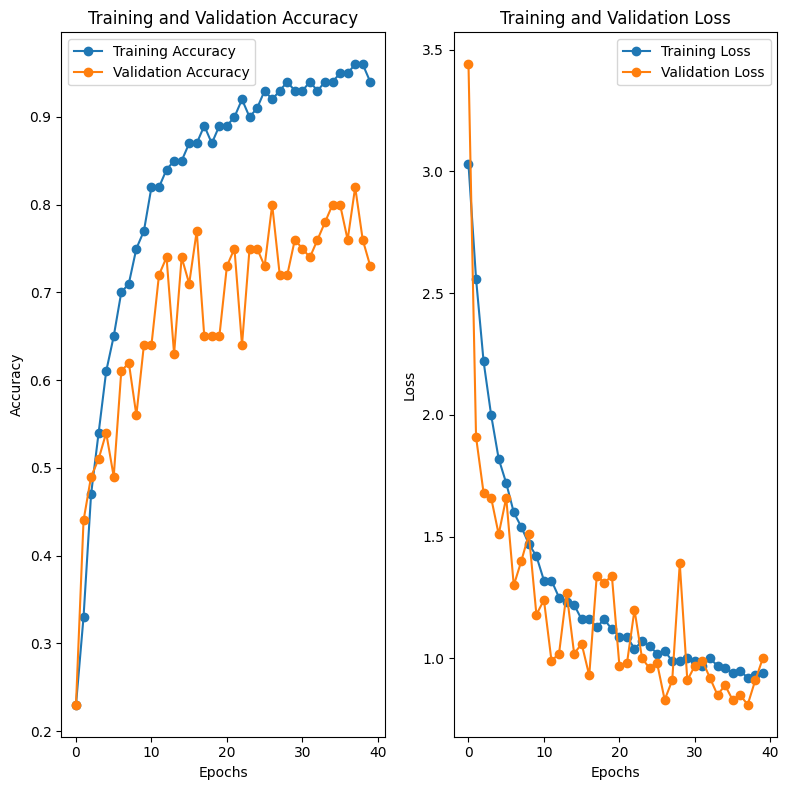

In [ ]:
resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)
test_plot(resnet18,hyperparameters)

### Testing different batch size

Testing with batch_size = 4


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.85


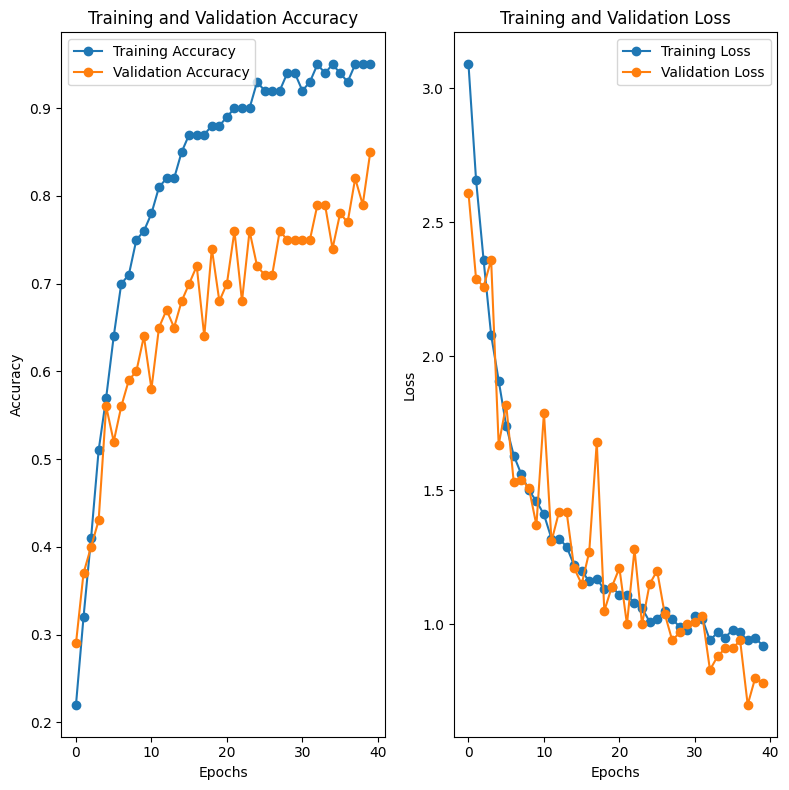

--------------------------------------------------------------------------------
Testing with batch_size = 16


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.82


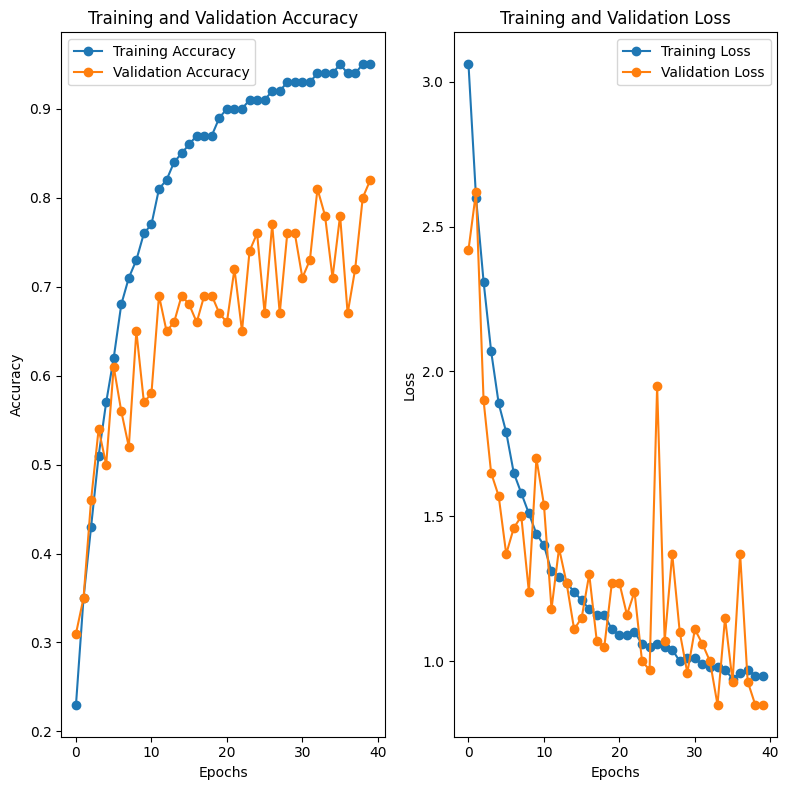

--------------------------------------------------------------------------------
Testing with batch_size = 32


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 34, best acc 0.83


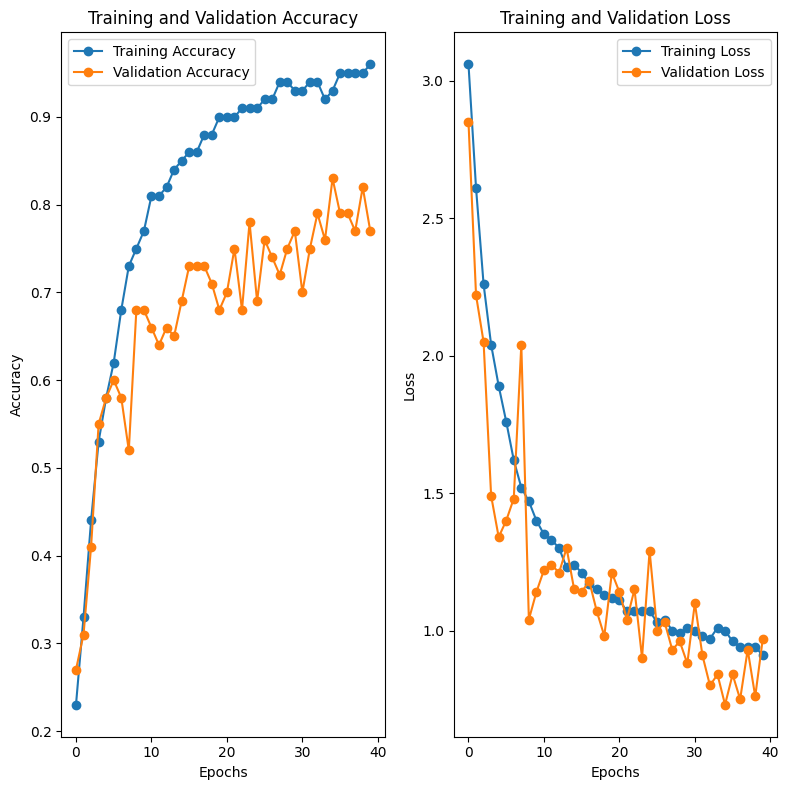

--------------------------------------------------------------------------------


In [ ]:
for batch in [4,16,32]:
  print(f"Testing with batch_size = {batch}")
  hyperparameters['batch_size']=batch
  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)
  test_plot(resnet18,hyperparameters)
  print('-'*80)
hyperparameters['batch_size']=8

### Testing different learning rates

Testing with learning rate = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.33


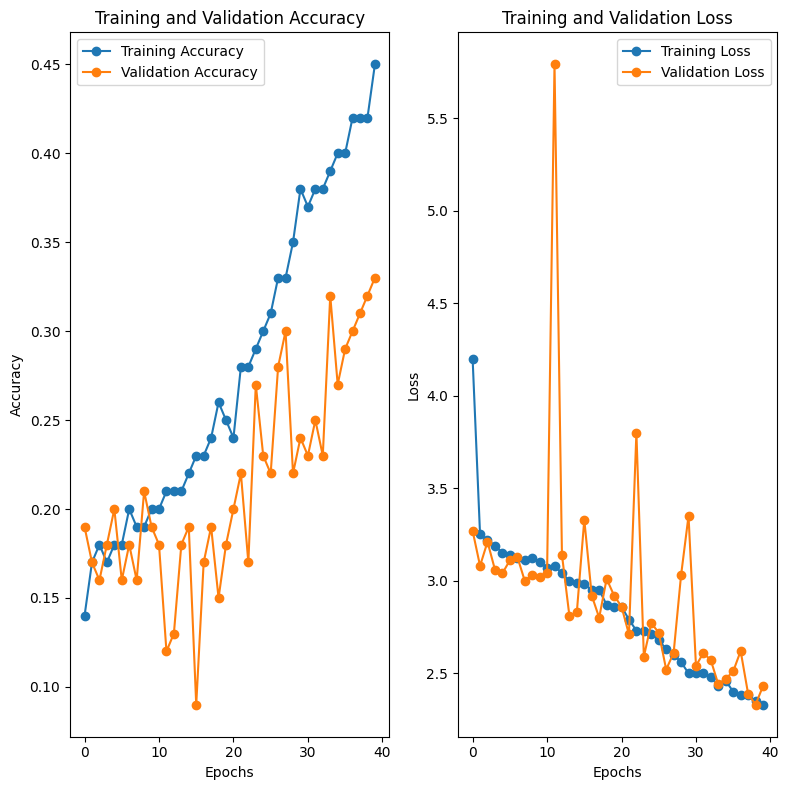

--------------------------------------------------------------------------------
Testing with learning rate = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 35, best acc 0.61


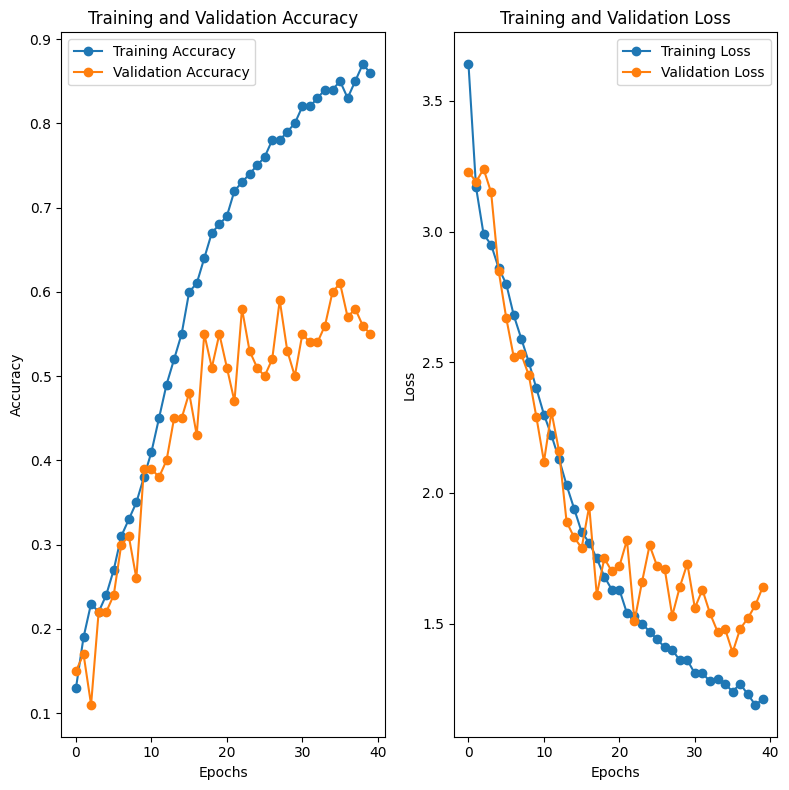

--------------------------------------------------------------------------------


In [ ]:
for lr in [0.1,0.01]:
  print(f"Testing with learning rate = {lr}")
  hyperparameters['lr']=lr
  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)
  test_plot(resnet18,hyperparameters)
  print('-'*80)

hyperparameters['lr']=0.001

### Testing different label smoothing

Testing with label smoothing = 0


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 33, best acc 0.76


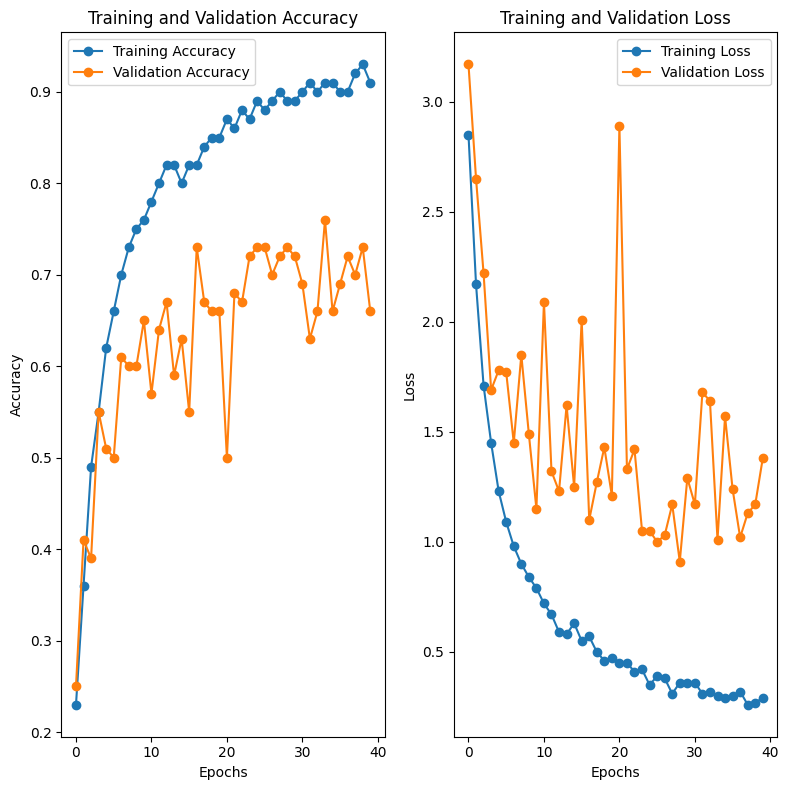

--------------------------------------------------------------------------------
Testing with label smoothing = 0.2


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.84


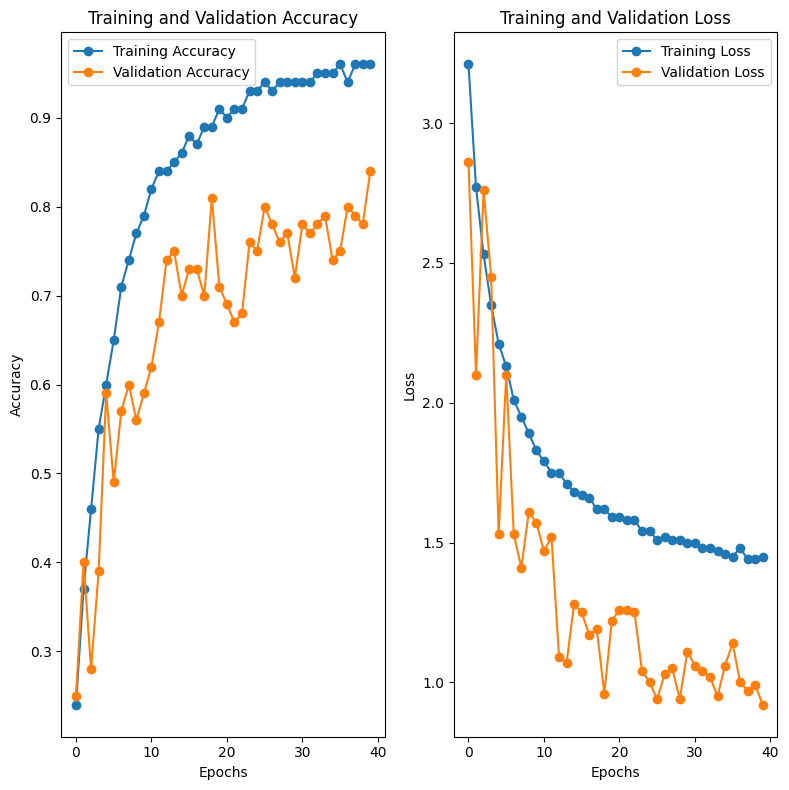

--------------------------------------------------------------------------------


In [ ]:
for ls in [0,0.2]:
  print(f"Testing with label smoothing = {ls}")
  hyperparameters['label_smoothing']=ls

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)

hyperparameters['label_smoothing']=0.1

### Testing different optimizers

Testing with SGD and weight decay = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 31, best acc 0.92


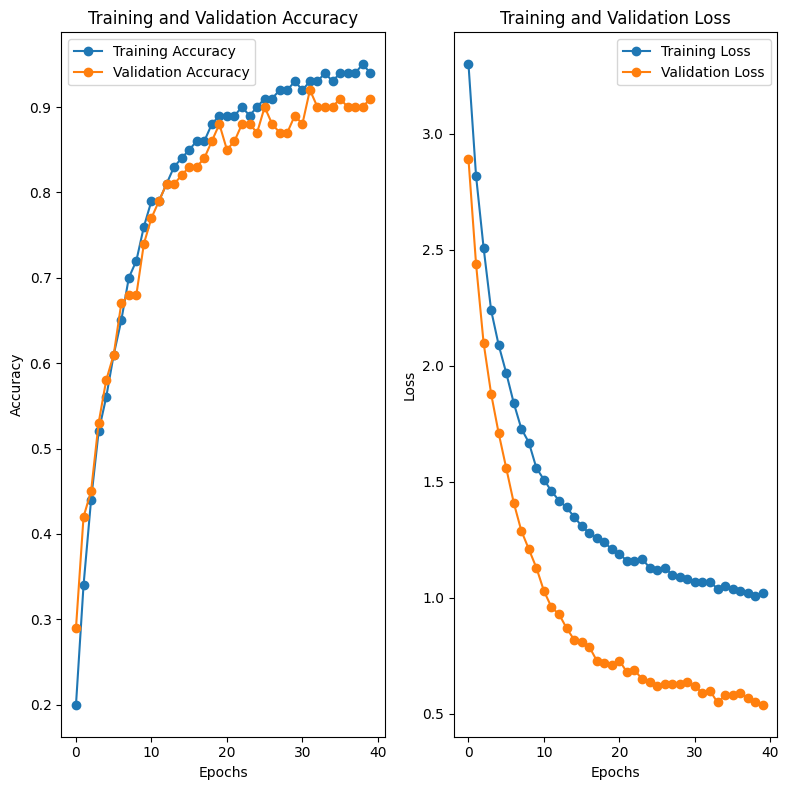

--------------------------------------------------------------------------------
Testing with SGD and weight decay = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 35, best acc 0.78


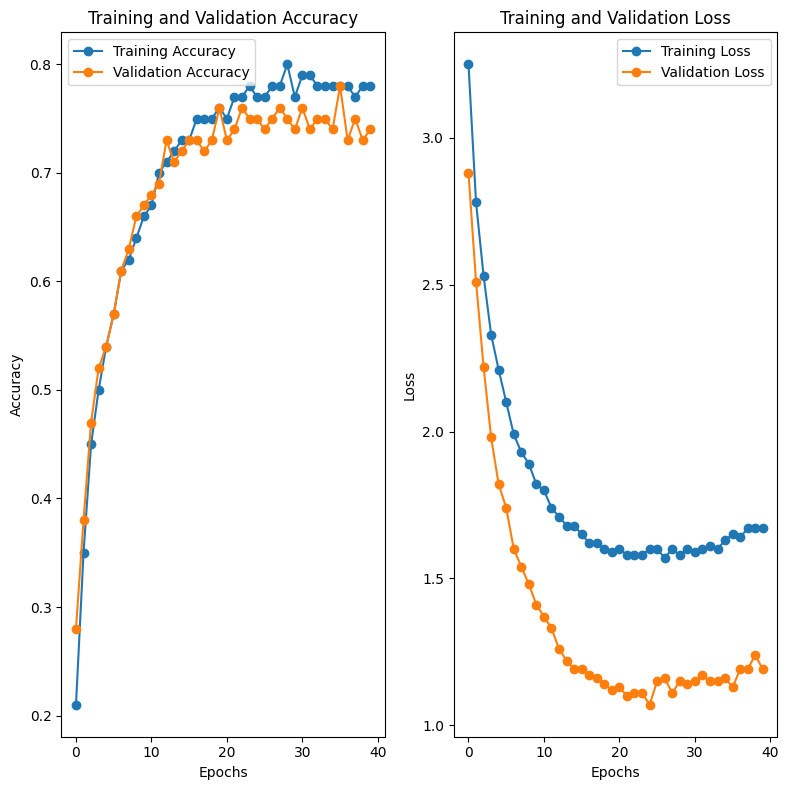

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'SGD'
for wd in [0.01, 0.1]:
  print(f"Testing with SGD and weight decay = {wd}")
  hyperparameters['wd']=wd

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)

Testing with AdamW and weight decay = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 36, best acc 0.83


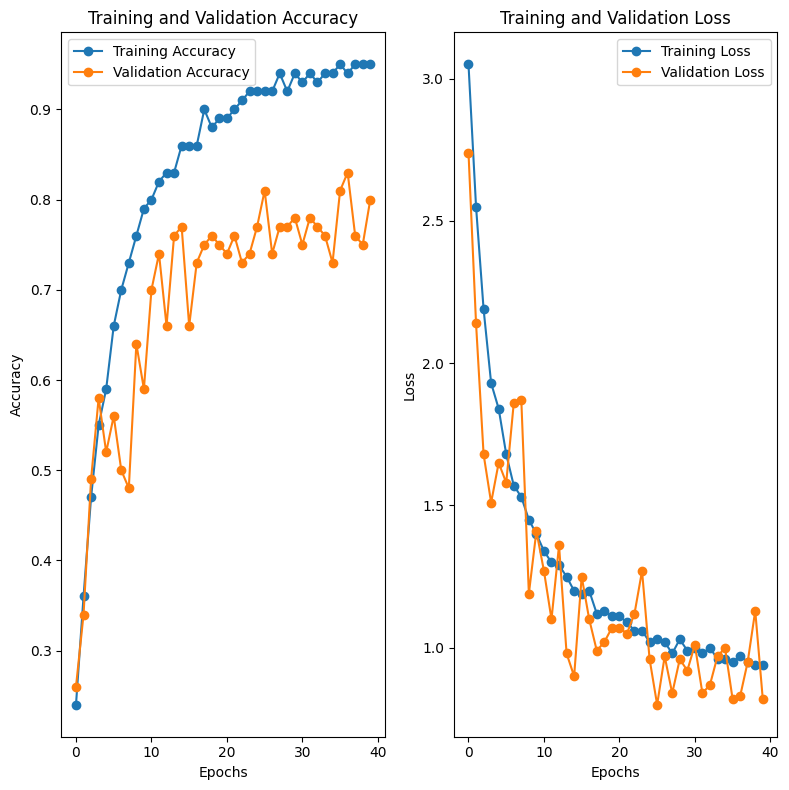

--------------------------------------------------------------------------------
Testing with AdamW and weight decay = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 38, best acc 0.80


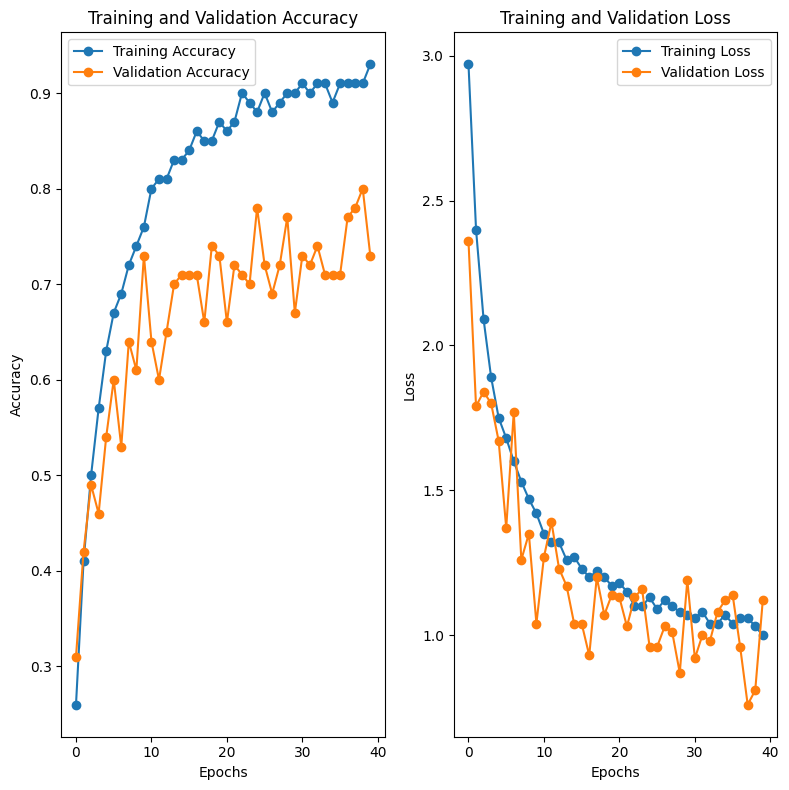

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'AdamW'
for wd in [0.01, 0.1]:
  print(f"Testing with AdamW and weight decay = {wd}")
  hyperparameters['wd']=wd

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)
hyperparameters['wd']=0
hyperparameters['optimizer']='Adam'

### Test freezing


In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    for p in layer.parameters():
        p.requires_grad = train

In [ ]:
def test_plot_fine_tuning(model,hyperparameters):

    set_requires_grad(model.conv1, False)
    set_requires_grad(model.bn1, False)
    set_requires_grad(model.layer1, False)
    set_requires_grad(model.layer2, False)
    set_requires_grad(model.layer3, False)
    set_requires_grad(model.layer4, False)

    epochs = hyperparameters['num_epochs']
    if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
    elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
    elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])

    best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
      model,
      train_loader,
      epochs,
      optimizer,
      val_loader,
      verbose=False,
      label_smoothing = hyperparameters['label_smoothing'],
    )

    training_values = training_values[best_epoch:]
    validation_values = validation_values[best_epoch:]


    training_acc = []
    training_loss = []
    validation_acc=[]
    validation_loss=[]

    for train,val in zip(training_values,validation_values):
        training_acc.append(round(train[0], 2))
        training_loss.append(round(train[1], 2))
        validation_acc.append(round(val[0], 2))
        validation_loss.append(round(val[1], 2))

    sd = torch.load("/kaggle/working/best_model.pth")
    model.load_state_dict(sd)

    set_requires_grad(model.conv1, True)
    set_requires_grad(model.bn1, True)
    set_requires_grad(model.layer1, True)
    set_requires_grad(model.layer2, True)
    set_requires_grad(model.layer3, True)
    set_requires_grad(model.layer4, True)


    if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr']*0.1)
    elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd']*0.1)
    elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd']*0.1)

    print('Unfreezing layers')
    best_epoch_old = best_epoch
    best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
        model,
        train_loader,
        10,
        optimizer,
        val_loader,
        verbose=False,
        label_smoothing = hyperparameters['label_smoothing'],
    )

    for train,val in zip(training_values,validation_values):
        training_acc.append(round(train[0], 2))
        training_loss.append(round(train[1], 2))
        validation_acc.append(round(val[0], 2))
        validation_loss.append(round(val[1], 2))

    print(f"Best epoch {best_epoch+best_epoch_old}, best acc {best_val_acc:.2f}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

    ax1.plot(training_acc, label='Training Accuracy', marker='o')
    ax1.plot(validation_acc, label='Validation Accuracy', marker='o')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(training_loss, label='Training Loss', marker='o')
    ax2.plot(validation_loss, label='Validation Loss', marker='o')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
hyperparameters_freezing = {
    "batch_size": 8,
    "num_epochs": 30,

    "lr": 0.001,
    "optimizer":'Adam',
    "wd": 0,
    "label_smoothing": 0.1
}

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.25 - train acc 0.86 - valid loss 1.05 - valid acc 0.71
Epoch 1: train loss 1.12 - train acc 0.91 - valid loss 0.93 - valid acc 0.71
Epoch 2: train loss 1.05 - train acc 0.92 - valid loss 0.85 - valid acc 0.75
Epoch 3: train loss 1.02 - train acc 0.93 - valid loss 0.90 - valid acc 0.74
Epoch 4: train loss 0.99 - train acc 0.94 - valid loss 0.92 - valid acc 0.76
Epoch 5: train loss 0.97 - train acc 0.95 - valid loss 0.88 - valid acc 0.77
Epoch 6: train loss 0.93 - train acc 0.96 - valid loss 0.81 - valid acc 0.80
Epoch 7: train loss 0.94 - train acc 0.96 - valid loss 0.81 - valid acc 0.82
Epoch 8: train loss 0.92 - train acc 0.97 - valid loss 0.71 - valid acc 0.84
Epoch 9: train loss 0.92 - train acc 0.97 - valid loss 0.80 - valid acc 0.81
Best epoch 8, best acc 0.84
Best epoch 29, best acc 0.84


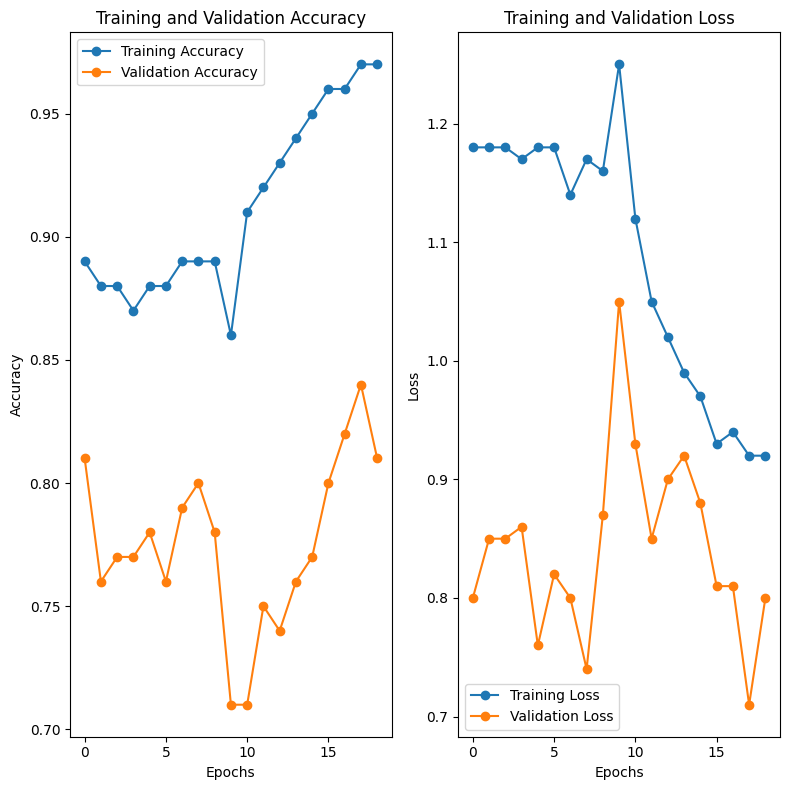

In [ ]:
resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

test_plot_fine_tuning(resnet18,hyperparameters_freezing)

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.68 - train acc 0.71 - valid loss 1.17 - valid acc 0.70
Epoch 1: train loss 1.54 - train acc 0.77 - valid loss 1.07 - valid acc 0.73
Epoch 2: train loss 1.45 - train acc 0.80 - valid loss 1.00 - valid acc 0.75
Epoch 3: train loss 1.39 - train acc 0.82 - valid loss 0.98 - valid acc 0.75
Epoch 4: train loss 1.35 - train acc 0.84 - valid loss 0.89 - valid acc 0.79
Epoch 5: train loss 1.29 - train acc 0.86 - valid loss 0.82 - valid acc 0.78
Epoch 6: train loss 1.25 - train acc 0.87 - valid loss 0.80 - valid acc 0.81
Epoch 7: train loss 1.25 - train acc 0.88 - valid loss 0.76 - valid acc 0.82
Epoch 8: train loss 1.22 - train acc 0.88 - valid loss 0.72 - valid acc 0.82
Epoch 9: train loss 1.18 - train acc 0.89 - valid loss 0.74 - valid acc 0.80
Best epoch 7, best acc 0.82
Best epoch 33, best acc 0.82


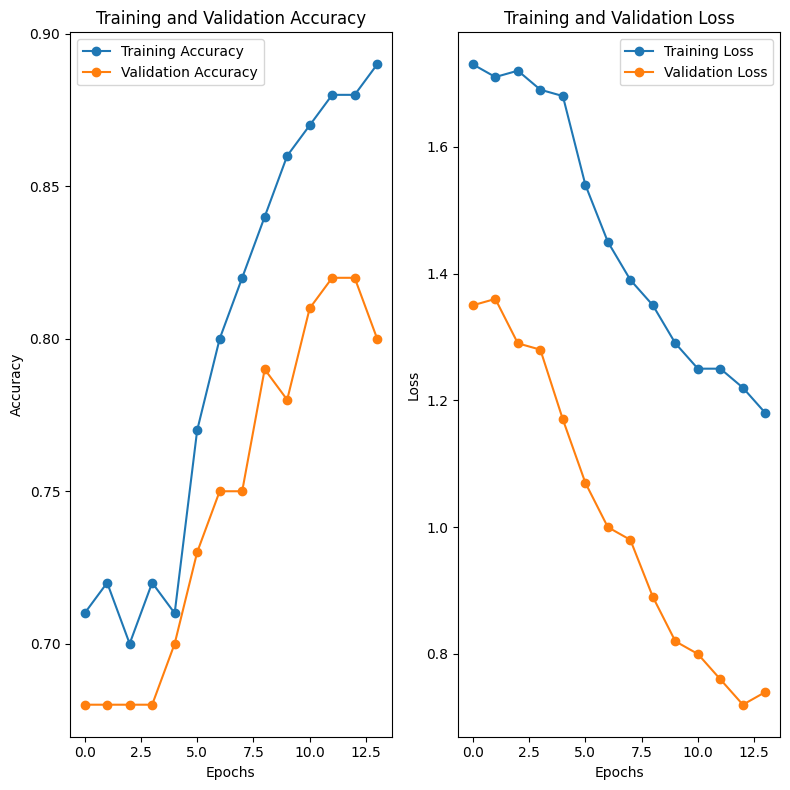

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.67 - train acc 0.73 - valid loss 1.25 - valid acc 0.66
Epoch 1: train loss 1.53 - train acc 0.77 - valid loss 1.09 - valid acc 0.72
Epoch 2: train loss 1.47 - train acc 0.79 - valid loss 1.04 - valid acc 0.73
Epoch 3: train loss 1.39 - train acc 0.82 - valid loss 0.94 - valid acc 0.78
Epoch 4: train loss 1.35 - train acc 0.83 - valid loss 0.91 - valid acc 0.78
Epoch 5: train loss 1.30 - train acc 0.86 - valid loss 0.88 - valid acc 0.80
Epoch 6: train loss 1.27 - train acc 0.86 - valid loss 0.81 - valid acc 0.80
Epoch 7: train loss 1.24 - train acc 0.88 - valid loss 0.81 - valid acc 0.80
Epoch 8: train loss 1.20 - train acc 0.90 - valid loss 0.75 - valid acc 0.81
Epoch 9: train loss 1.19 - train acc 0.90 - valid loss 0.80 - valid acc 0.81
Best epoch 8, best acc 0.81
Best epoch 33, best acc 0.81


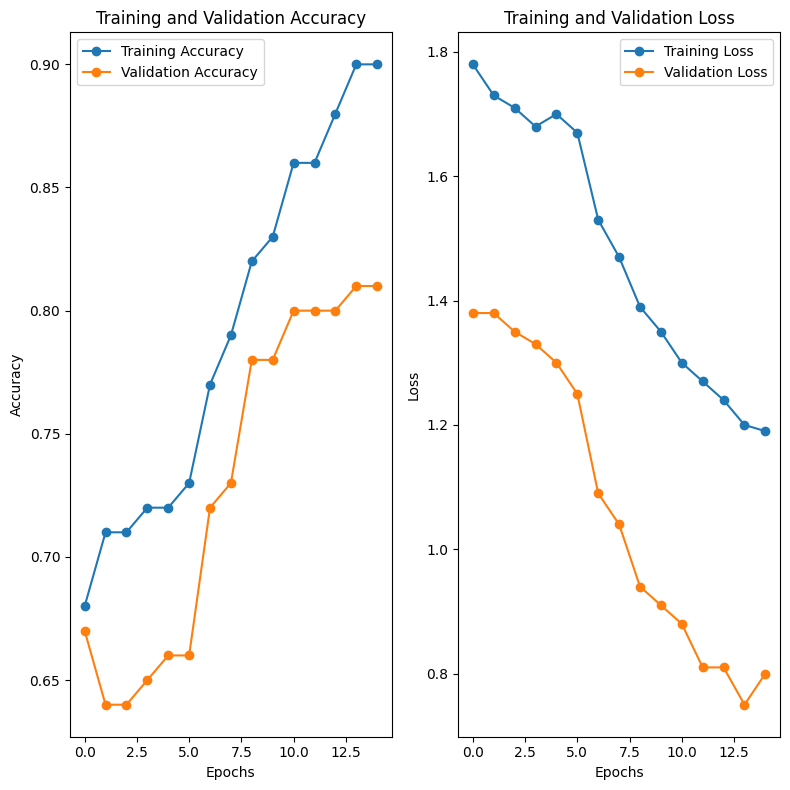

In [ ]:
hyperparameters_freezing['optimizer'] = 'SGD'
for wd in [0.01, 0.1]:
    resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    resnet18 = resnet18.to(device)

    test_plot_fine_tuning(resnet18,hyperparameters_freezing)


  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Best epoch 30, best acc 0.70


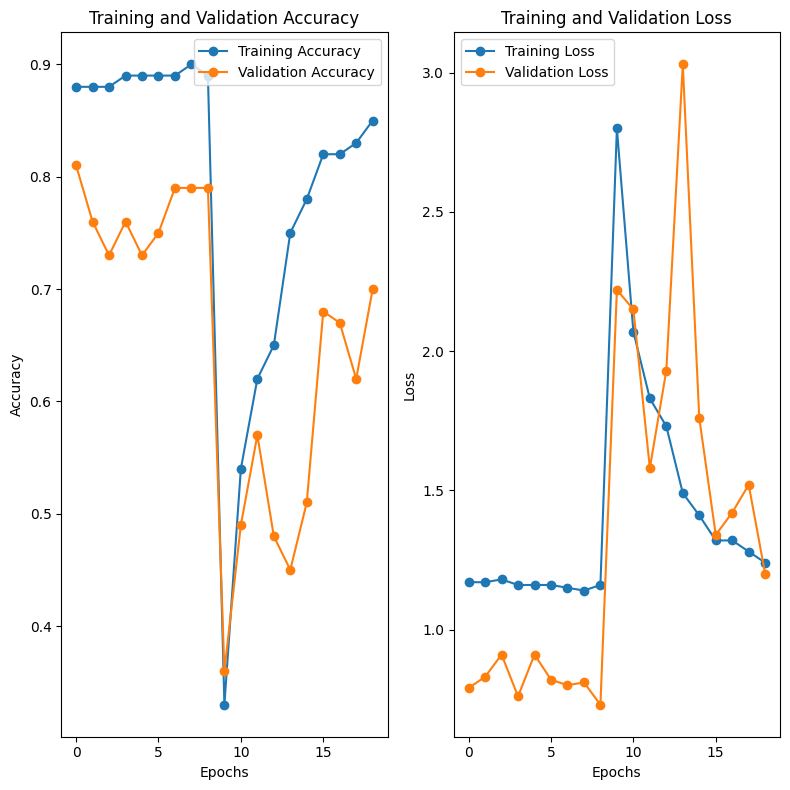

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Best epoch 28, best acc 0.70


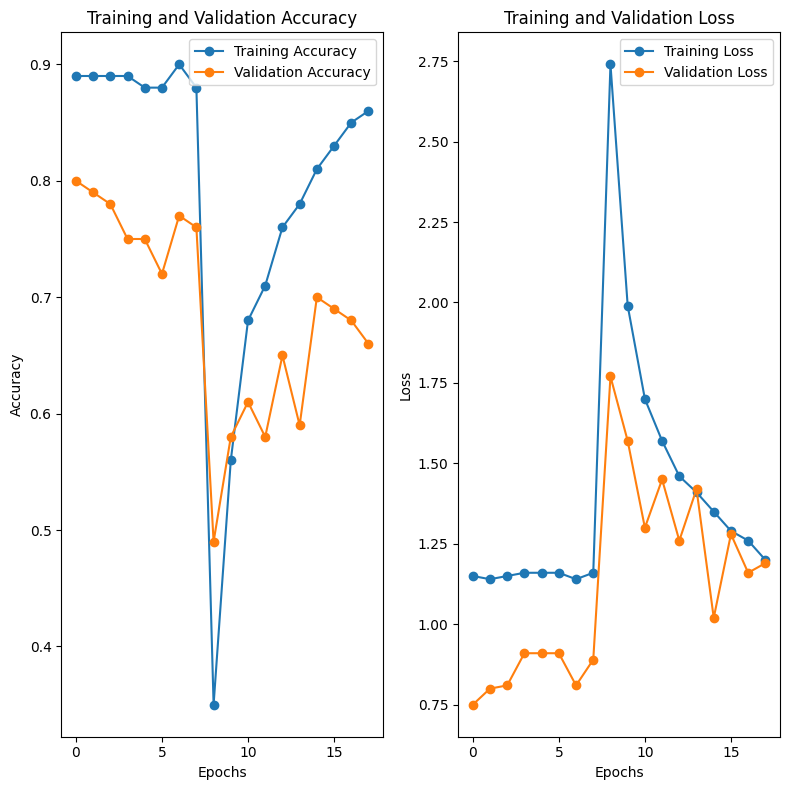

In [ ]:
hyperparameters_freezing['optimizer'] = 'AdamW'
for wd in [0.01, 0.1]:

    resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    resnet18 = resnet18.to(device)

    test_plot_fine_tuning(resnet18,hyperparameters_freezing)